# EVALUATION LOOP

In [1]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel, OpenAIAdvanced
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import helpers

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 1             # demos per query
NUM_SAMPLES = 1           # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder = MathBERTEncoder(device=DEVICE, trainable=False)
encoder.eval()                                   # no grads!

icl_model = OpenAIAdvanced(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
train_path = "./data/MATH/train.jsonl"
train_ds_list = helpers.load_jsonl(train_path)[:40]
raw_demos = helpers.load_jsonl(train_path)[:256]

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

# Build demo pool (everything except current query)

for idx in tqdm(range(len(train_ds_list)), desc="Baseline eval"):
    item       = train_ds_list[idx]
    Q_inf, A_gt, A_ans = item["problem"], item["solution"], item["answer"]
    demos = [(d["problem"], d["solution"], d["answer"])
                for j, d in enumerate(raw_demos) if j != idx]
        
    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q,_, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    print("Solution: ", A_ans)
    print("Response: ", flat_responses[0])
    acc = compute_demo_accuracy(flat_responses, A_ans)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on MATH500: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/40 [00:00<?, ?it/s]

🔍 Top-K Indices: [149]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:   2%|▎         | 1/40 [00:02<01:46,  2.73s/it]

Solution:  2
Response:  2
['2']
1.0
🔍 Top-K Indices: [104]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:   5%|▌         | 2/40 [00:04<01:32,  2.44s/it]

Solution:  18
Response:  18
['18']
1.0
🔍 Top-K Indices: [109]
[INFO] Launching 1 parallel inference tasks...
Solution:  \dfrac{7}{20}
Response:  \frac{1}{2}
['\\frac{1}{2}']


Baseline eval:   8%|▊         | 3/40 [00:10<02:29,  4.04s/it]

0.0
🔍 Top-K Indices: [159]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  10%|█         | 4/40 [00:13<02:01,  3.37s/it]

Solution:  1.36
Response:  \boxed{1.36}
['\\boxed{1.36}']
1.0
🔍 Top-K Indices: [113]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  12%|█▎        | 5/40 [00:20<02:50,  4.86s/it]

Solution:  28
Response:  676
['676']
0.0
🔍 Top-K Indices: [76]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  15%|█▌        | 6/40 [00:26<02:53,  5.10s/it]

Solution:  \frac{2 \sqrt{149}}{3}
Response:  \frac{2\sqrt{149}}{3}
['\\frac{2\\sqrt{149}}{3}']
1.0
🔍 Top-K Indices: [64]
[INFO] Launching 1 parallel inference tasks...
Solution:  3\sqrt{3}
Response:   rac{2bc \, \, 	ext{cos} \frac{A}{2}}{b+c} 

In triangle ABC, sides are: 
AB = AC = 14, BC = 26.
Using the Law of Cosines to find angle A:

cos A = \frac{b^2 + c^2 - a^2}{2bc} = \frac{14^2 + 14^2 - 26^2}{2 \times 14 \times 14} = \frac{196 + 196 - 676}{392} = \frac{-284}{392} = -\frac{71}{98}.

Now, the angle A:
A = \arccos \left(-\frac{71}{98}\right).

The angle bisector from A has length:

l_a = \frac{2bc \sin \frac{A}{2}}{b + c}.

Since b = c = 14, this simplifies to:

l_a = \frac{2 \times 14 \times 14 \sin \frac{A}{2}}{14 + 14} = \frac{392 \sin \frac{A}{2}}{28} = 14 \sin \frac{A}{2}.

Using the half-angle formula:

\sin \frac{A}{2} = \sqrt{\frac{1 - \cos A}{2}} = \sqrt{\frac{1 - (-\frac{71}{98})}{2}} = \sqrt{\frac{1 + \frac{71}{98}}{2}} = \sqrt{\frac{\frac{98}{98} + \frac{71}{98}}{2}}

Baseline eval:  18%|█▊        | 7/40 [00:35<03:29,  6.35s/it]

0.0
🔍 Top-K Indices: [204]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  20%|██        | 8/40 [00:38<02:52,  5.38s/it]

Solution:  10\sqrt{2}
Response:  10\sqrt{2}
['10\\sqrt{2}']
1.0
🔍 Top-K Indices: [72]
[INFO] Launching 1 parallel inference tasks...
Solution:  3\sqrt{2}
Response:  54
['54']


Baseline eval:  22%|██▎       | 9/40 [00:43<02:40,  5.17s/it]

0.0
🔍 Top-K Indices: [154]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  25%|██▌       | 10/40 [00:46<02:13,  4.46s/it]

Solution:  \text{June 20}
Response:  \textbf{June 20
['\\textbf{June 20']
1.0
🔍 Top-K Indices: [194]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  28%|██▊       | 11/40 [00:53<02:37,  5.44s/it]

Solution:  32736
Response:  32861
['32861']
0.0
🔍 Top-K Indices: [151]
[INFO] Launching 1 parallel inference tasks...
Solution:  735
Response:  $ (33 \times 21.95) + (33 \times 2.55) = 33 \times (21.95 + 2.55) = 33 \times 24.50 = \boxed{808.50}.
['$ (33 \\times 21.95) + (33 \\times 2.55) = 33 \\times (21.95 + 2.55) = 33 \\times 24.50 = \\boxed{808.50}.']


Baseline eval:  30%|███       | 12/40 [00:57<02:16,  4.89s/it]

0.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  32%|███▎      | 13/40 [01:02<02:16,  5.07s/it]

Solution:  5
Response:  5
['5']
1.0
🔍 Top-K Indices: [62]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  35%|███▌      | 14/40 [01:04<01:47,  4.13s/it]

Solution:  2
Response:  2
['2']
1.0
🔍 Top-K Indices: [109]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  38%|███▊      | 15/40 [01:12<02:06,  5.04s/it]

Solution:  5
Response:  5
['5']
1.0
🔍 Top-K Indices: [241]
[INFO] Launching 1 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=407, total_tokens=2455, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=407, total_tokens=2455, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was

Baseline eval:  40%|████      | 16/40 [01:57<06:54, 17.27s/it]

Turning text into JSON by brute force...
Solution:  \frac{416}{27}
Response:  \frac{416}{27}
['\\frac{416}{27}']
1.0
🔍 Top-K Indices: [192]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  42%|████▎     | 17/40 [02:01<05:01, 13.09s/it]

Solution:  19
Response:  19
['19']
1.0
🔍 Top-K Indices: [126]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  45%|████▌     | 18/40 [02:03<03:37,  9.90s/it]

Solution:  27
Response:  27
['27']
1.0
🔍 Top-K Indices: [192]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  48%|████▊     | 19/40 [02:06<02:44,  7.85s/it]

Solution:  50
Response:  50
['50']
1.0
🔍 Top-K Indices: [41]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  50%|█████     | 20/40 [02:10<02:11,  6.57s/it]

Solution:  \text{even}
Response:  even
['even']
1.0
🔍 Top-K Indices: [45]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  52%|█████▎    | 21/40 [02:15<01:55,  6.07s/it]

Solution:  \sqrt{10}
Response:  \sqrt{10}
['\\sqrt{10}']
1.0
🔍 Top-K Indices: [222]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  55%|█████▌    | 22/40 [02:17<01:30,  5.05s/it]

Solution:  4
Response:  4
['4']
1.0
🔍 Top-K Indices: [229]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  57%|█████▊    | 23/40 [02:21<01:18,  4.62s/it]

Solution:  \frac{2}{3}
Response:  \frac{2}{3}
['\\frac{2}{3}']
1.0
🔍 Top-K Indices: [115]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  60%|██████    | 24/40 [02:24<01:05,  4.11s/it]

Solution:  15
Response:  15
['15']
1.0
🔍 Top-K Indices: [123]
[INFO] Launching 1 parallel inference tasks...
Solution:  336
Response:  \( 8 \times 7 \times 6 = 336 \)
['\\( 8 \\times 7 \\times 6 = 336 \\)']


Baseline eval:  62%|██████▎   | 25/40 [02:27<00:55,  3.69s/it]

0.0
🔍 Top-K Indices: [5]
[INFO] Launching 1 parallel inference tasks...
Solution:  \frac{1}{5}, -\frac{1}{3}
Response:  -\frac{1}{3}
['-\\frac{1}{3}']


Baseline eval:  65%|██████▌   | 26/40 [02:32<00:58,  4.21s/it]

0.0
🔍 Top-K Indices: [16]
[INFO] Launching 1 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=387, total_tokens=2435, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=387, total_tokens=2435, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(comple

Baseline eval:  68%|██████▊   | 27/40 [03:05<02:48, 12.95s/it]

Turning text into JSON by brute force...
Solution:  11
Response:  11
['11']
1.0
🔍 Top-K Indices: [112]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  70%|███████   | 28/40 [03:09<02:02, 10.23s/it]

Solution:  \begin{pmatrix} 8 & 12 \\ -4 & 20 \end{pmatrix}
Response:  \\begin{pmatrix} 8 & 12 \\ -4 & 20 \\end{pmatrix}
['\\\\begin{pmatrix} 8 & 12 \\\\ -4 & 20 \\\\end{pmatrix}']
1.0
🔍 Top-K Indices: [229]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  72%|███████▎  | 29/40 [03:13<01:32,  8.45s/it]

Solution:  11
Response:  12
['12']
0.0
🔍 Top-K Indices: [79]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  75%|███████▌  | 30/40 [03:16<01:07,  6.75s/it]

Solution:  0
Response:  0
['0']
1.0
🔍 Top-K Indices: [243]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  78%|███████▊  | 31/40 [03:19<00:49,  5.53s/it]

Solution:  4
Response:  4
['4']
1.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...
Solution:  18\text{ ways.}
Response:  $12$
['$12$']


Baseline eval:  80%|████████  | 32/40 [03:22<00:38,  4.80s/it]

0.0
🔍 Top-K Indices: [97]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  82%|████████▎ | 33/40 [03:24<00:28,  4.05s/it]

Solution:  9
Response:  9
['9']
1.0
🔍 Top-K Indices: [36]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  85%|████████▌ | 34/40 [03:27<00:21,  3.66s/it]

Solution:  \frac{i}{5}
Response:  z = \frac{i}{5}
['z = \\frac{i}{5}']
1.0
🔍 Top-K Indices: [48]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  88%|████████▊ | 35/40 [03:30<00:16,  3.37s/it]

Solution:  90
Response:  90
['90']
1.0
🔍 Top-K Indices: [41]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  90%|█████████ | 36/40 [03:33<00:12,  3.19s/it]

Solution:  y^4-2y^3+7y^2+y-5
Response:  $y^4 - 2y^3 + 7y^2 + y - 5$
['$y^4 - 2y^3 + 7y^2 + y - 5$']
1.0
🔍 Top-K Indices: [166]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  92%|█████████▎| 37/40 [03:35<00:08,  2.91s/it]

Solution:  120
Response:  \boxed{120}
['\\boxed{120}']
1.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  95%|█████████▌| 38/40 [03:37<00:05,  2.77s/it]

Solution:  20
Response:  20
['20']
1.0
🔍 Top-K Indices: [26]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  98%|█████████▊| 39/40 [03:40<00:02,  2.62s/it]

Solution:  400
Response:  400
['400']
1.0
🔍 Top-K Indices: [96]
[INFO] Launching 1 parallel inference tasks...


Baseline eval: 100%|██████████| 40/40 [03:42<00:00,  5.57s/it]

Solution:  2
Response:  2
['2']
1.0

📊  Baseline accuracy on MATH500: 75.000%


In [ ]:
import helpers
train_path = "./data/MATH/train.jsonl"
train_ds_list = helpers.load_jsonl(train_path)
print(train_ds_list[0])

{'problem': 'How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have?', 'solution': 'The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\\boxed{2}$ vertical asymptotes.', 'answer': '2', 'subject': 'Algebra', 'level': 3, 'unique_id': 'test/algebra/1.json'}


# TRAINING LOOP

In [ ]:
from tqdm import tqdm
import torch
import helpers
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel, OpenAIAdvanced
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

# === Settings ===
API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K = 10
NUM_SAMPLES_PER_DEMO = 4
LEARNING_RATE =  5e-5
MAX_STEPS = 20
TEMPERATURE = 0.1

# === Init ===
encoder = MathBERTEncoder(device=DEVICE, trainable=True)
encoder.train()

icl_model = OpenAIAdvanced(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
WARMUP_STEPS = 3 # Define number of warmup steps for the scheduler

# Initialize the Learning Rate Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=MAX_STEPS
)
train_path = "./data/MATH/train.jsonl"
all_examples = helpers.load_jsonl(train_path)
train_ds_list = all_examples[:20]
raw_demos = all_examples[:128]

# === Training Loop ===
reward_history = []
N = len(train_ds_list)
active_indices = list(range(N))

for step in range(MAX_STEPS):
    print(f"\n=== Training Step {step+1} ===")
    epoch_rewards = [None] * N                # default to None for every example
    next_active = []

    # loop only over the “hard” examples
    for idx in tqdm(active_indices, desc="Examples"):
        item = train_ds_list[idx]
        Q_inf, A_gt, A_ans = item["problem"], item["solution"], item["answer"]

        # --- encode & retrieve as before ---
        q_emb = encoder.encode([Q_inf], detach=False).squeeze(0)
        demo_pool = [d for j, d in enumerate(raw_demos) if j != idx]
        demo_questions = [d["problem"] for d in demo_pool]
        demo_embs = encoder.batched_encode(demo_questions, batch_size=16, detach=False)
        top_k_inds, sims = rc.retrieve_top_k_cosine(q_emb, demo_embs, k=min(K, len(demo_questions)))
        
        top_k_inds_adj = [i if i < idx else i + 1 for i in top_k_inds]
        print("-------Question---------")
        print(Q_inf)
        print(f"\n🧠 Inference Index {idx}")
        print(f"🔍 Top-K Indices: {top_k_inds_adj}")
        top_k_inds, sims = rc.retrieve_sample_k_cosine(q_emb, demo_embs, k=min(K, len(demo_questions)))
        top_k_inds_adj = [i.item() if i.item() < idx else i.item() + 1 for i in top_k_inds]
        print(f"❗ Sampled Indices: {top_k_inds_adj}")
        
        

        selected = [(raw_demos[i], i) for i in top_k_inds_adj]
        # Remember the demo_q's that was selected here. 
        
        # --- sample responses & compute mean reward ---
        responses_nested = sample_responses_per_demo(
            demo_tuples=[(d[0]["problem"], d[0]["solution"], d[0]["answer"],d[1]) for d in selected],
            Q_inf=Q_inf,
            icl_model=icl_model,
            num_samples=NUM_SAMPLES_PER_DEMO,
            parallel=True
        )
        print("Responses_nested:", responses_nested)
        rewards = []
        print("Responses: ", responses_nested)
        for i, responses in enumerate(responses_nested):
            reward = compute_demo_accuracy(responses, A_ans)
            rewards.append(reward)
            # print(f"    Demo {i} | Reward: {reward:.2f}")
        
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        print("Rewards tensor:", rewards)
        print("Sims tensor:", sims)
        loss = grpo_step(
            rewards,
            sims,
            q_emb,
            demo_embs,
            optimizer
        )
        scheduler.step()

        mean_r = rewards.mean().item()
        epoch_rewards[idx] = mean_r

        # decide whether to keep for next epoch
        if mean_r <= 0.75:
            next_active.append(idx)

        print(f"✅  idx={idx} | Mean Reward: {mean_r:.4f} | Loss: {loss:.4f}")

    # record this epoch’s full reward vector (with Nones)
    reward_history.append(epoch_rewards)

    dropped = len(active_indices) - len(next_active)
    print(f"Epoch {step+1}: dropped {dropped} examples (mean_r > 0.75).")
    active_indices = next_active

    if not active_indices:
        print("All examples have converged—stopping early.")
        break




=== Training Step 1 ===


Examples:   0%|          | 0/20 [00:00<?, ?it/s]

-------Question---------
How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?

🧠 Inference Index 0
🔍 Top-K Indices: [117, 57, 75, 69, 77, 52, 25, 66, 110, 12]
❗ Sampled Indices: [117, 69, 12, 75, 33, 77, 95, 57, 58, 76]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\boxed{2}', '2', 'x = -3 \\text{ and } x = 2', '\\boxed{2}'], ['\\boxed{2}', '\\boxed{2}', 'x = -3 \\text{ and } x = 2', 'x = -3 \\text{ and } x = 2'], ['x = -3 \\text{ and } x = 2', 'x = -3 \text{ and } x = 2', 'x = -3 \\text{ and } x = 2', 'x = -3 \text{ and } x = 2'], ['2', 'x = -3 \\text{ and } x = 2', 'x = -3 \\text{ and } x = 2', 'x = -3 \\text{ and } x = 2'], ['x = -3 \\text{ and } x = 2', '2', 'x = -3 \\text{ and } x = 2', 'x = -3 \\text{ and } x = 2'], ['\\boxed{2}', '\\boxed{2}', '\\boxed{2}', '\\boxed{2}'], ['x = -3 \\text{ and } x = 2', 'x = -3 \text{ and } x = 2', 'x = -3 \text{ and } x = 2', 'x = -3 \\text{ and } x = 2'], ['2', '2', '2', '2'], ['\\boxed{2}', '2', '2

Examples:   5%|▌         | 1/20 [00:08<02:42,  8.54s/it]

✅  idx=0 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
If $5x - 3 = 12$, what is the value of $5x + 3$?

🧠 Inference Index 1
🔍 Top-K Indices: [111, 106, 108, 82, 16, 100, 99, 105, 96, 65]
❗ Sampled Indices: [106, 111, 53, 84, 108, 99, 100, 16, 105, 18]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18']]
Responses:  [['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18'], ['18', '18', '18', '18']]
Rewards tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Sims tensor: tensor([-1.7889, -0.8011, -5.6572, 

Examples:  10%|█         | 2/20 [00:17<02:35,  8.64s/it]

✅  idx=1 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
Ryan has 3 red lava lamps and 3 blue lava lamps. He arranges them in a row on a shelf randomly, then turns 3 random lamps on. What is the probability that the leftmost lamp on the shelf is red, and the leftmost lamp which is turned on is also red?

🧠 Inference Index 2
🔍 Top-K Indices: [34, 24, 31, 9, 110, 54, 70, 94, 100, 93]
❗ Sampled Indices: [95, 34, 62, 24, 118, 117, 49, 110, 31, 9]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\boxed{\\frac{1}{4}}', '\\frac{1}{4}', '\\( \\boxed{\\frac{1}{4}} \\)', '\\( \\frac{1}{4} \\)'], ['\\frac{1}{4}', '\\( \\frac{1}{2} \\)', '\\( \\frac{1}{2} \\)', '\\( \\frac{1}{4} \\)'], ['\\frac{7}{20}', '\\frac{1}{4}', '\\frac{1}{4}', '\\frac{1}{2}'], ['\\frac{\\text{Number of arrangements with leftmost lamp red and leftmost turned on red}}{20}.', '\\frac{1}{2}', '\\frac{1}{30}', '\\(\\frac{1}{4}\\)'], ['\\frac{1}{4}', '\\frac{1}{4}', '\\frac{1}{4}', '\\frac{3}{

Examples:  15%|█▌        | 3/20 [00:59<06:44, 23.79s/it]

✅  idx=2 | Mean Reward: 0.0750 | Loss: 0.5012
-------Question---------
Alice wants to buy $3$ pounds of veal at the grocery store, but the scales at the store only show weight in kilograms. If one kilogram is $2.20$ pounds, how many kilograms of veal should Alice buy?  (You may use a calculator on this problem; answer to the nearest hundredth.)

🧠 Inference Index 3
🔍 Top-K Indices: [93, 69, 85, 94, 12, 35, 127, 14, 31, 113]
❗ Sampled Indices: [93, 69, 66, 85, 110, 12, 21, 94, 14, 31]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['1.36 kg', '1.36', '1.36', '1.36'], ['1.36 kg', '1.36 kg', '1.36 kg', '1.36 kg'], ['1.36 kg', '1.36 kg', '1.36 kg', '$1.36$ kilograms'], ['\text{Approximately } 1.36 \text{ kilograms}', '1.36', '1.36 kg', '1.36'], ['1.36 kg', '1.36 kg', '1.36 kg', '1.36 kg'], ['\x08oxed{1.36}', '1.36 kg', '1.36', '1.36 kg'], ['1.36', '1.36 kg', '1.36', '1.36'], ['1.36', '1.36', '1.36', '1.36'], ['1.36', '1.36', '1.36', '1.36'], ['\x08oxed{1.36}', '\\boxed{

Examples:  20%|██        | 4/20 [01:05<04:29, 16.84s/it]

✅  idx=3 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
On the $xy$-plane, the origin is labeled with an $M$. The points $(1,0)$, $(-1,0)$, $(0,1)$, and $(0,-1)$ are labeled with $A$'s. The points $(2,0)$, $(1,1)$, $(0,2)$, $(-1, 1)$, $(-2, 0)$, $(-1, -1)$, $(0, -2)$, and $(1, -1)$ are labeled with $T$'s. The points $(3,0)$, $(2,1)$, $(1,2)$, $(0, 3)$, $(-1, 2)$, $(-2, 1)$, $(-3, 0)$, $(-2,-1)$, $(-1,-2)$, $(0, -3)$, $(1, -2)$, and $(2, -1)$ are labeled with $H$'s. If you are only allowed to move up, down, left, and right, starting from the origin, how many distinct paths can be followed to spell the word MATH?

🧠 Inference Index 4
🔍 Top-K Indices: [114, 78, 85, 11, 122, 7, 94, 41, 3, 83]
❗ Sampled Indices: [114, 78, 85, 11, 122, 7, 94, 9, 3, 83]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['36', '\\boxed{512}', '1536', '192'], ['6', 'The total number of paths is 64.', "\n\\begin{aligned}\n&\\text{Number of paths from M (0,0) to A points:} \\\\ \n

Examples:  25%|██▌       | 5/20 [01:40<05:54, 23.62s/it]

✅  idx=4 | Mean Reward: 0.0000 | Loss: -0.0000
-------Question---------
One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$  A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$  The two spheres intersect in a circle.  Find the radius of this circle.

🧠 Inference Index 5
🔍 Top-K Indices: [53, 123, 25, 21, 42, 77, 99, 87, 57, 74]
❗ Sampled Indices: [25, 53, 21, 77, 42, 123, 99, 57, 91, 102]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=471, total_tokens=4071, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_token

Examples:  30%|███       | 6/20 [02:45<08:47, 37.71s/it]

✅  idx=5 | Mean Reward: 0.6500 | Loss: 0.0449
-------Question---------
In triangle $\triangle ABC,$ we have that $AB = AC = 14$ and $BC = 26.$ What is the length of the shortest angle bisector in $ABC$? Express your answer in simplest radical form.

🧠 Inference Index 6
🔍 Top-K Indices: [105, 100, 65, 80, 123, 73, 28, 101, 18, 86]
❗ Sampled Indices: [51, 80, 65, 105, 81, 28, 123, 67, 39, 95]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=300, total_tokens=3900, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=779

Examples:  35%|███▌      | 7/20 [04:09<11:24, 52.62s/it]

✅  idx=6 | Mean Reward: 0.6500 | Loss: 0.7282
-------Question---------
$AB = 20$ cm, $m \angle A = 30^\circ$, and $m \angle C = 45^\circ$. Express the number of centimeters in the length of $\overline{BC}$ in simplest radical form. [asy]
import olympiad; size(200); import geometry; import graph; defaultpen(linewidth(0.8));
pair A = origin, B = (10*sqrt(3),10), C = (10*sqrt(3) + 10,0);
draw(Label("$20$",align=NW),A--B); draw(B--C); draw(A--C);
label("$A$",A,W); label("$B$",B,N); label("$C$",C,E);
[/asy]

🧠 Inference Index 7
🔍 Top-K Indices: [122, 114, 85, 78, 11, 4, 94, 76, 77, 14]
❗ Sampled Indices: [122, 114, 85, 11, 78, 4, 14, 94, 76, 113]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\( 10 \\sqrt{2} \\)', '10 \\sqrt{2}', '$10\\sqrt{2}$', '20\\sqrt{2}'], ['10\\sqrt{2}', '10\\sqrt{2}', '10\\sqrt{2}', '10\\sqrt{2}'], ['\\( 10 \\sqrt{2} \\)', '$10\\sqrt{2}$', '$10\\left(\\sqrt{6} - \\sqrt{2}\\right)$', '$10\\left(\\sqrt{6} - \\sqrt{2}\\right)$'], ['$10\\sqrt{2}$'

Examples:  40%|████      | 8/20 [04:26<08:16, 41.36s/it]

✅  idx=7 | Mean Reward: 0.9250 | Loss: 2.4195
-------Question---------
We have two geometric sequences of positive real numbers: $$6,a,b\text{ and }\frac{1}{b},a,54$$Solve for $a$.

🧠 Inference Index 8
🔍 Top-K Indices: [16, 73, 28, 67, 58, 88, 102, 101, 99, 54]
❗ Sampled Indices: [67, 15, 58, 54, 28, 39, 16, 101, 73, 84]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['$a = 3\\sqrt{2}$', '$a = 3\\sqrt{2}$', '\\( \\boxed{\\sqrt[4]{324}} \\)', '\\( \\boxed{\\sqrt[4]{324}} \\)'], ['3\\sqrt{2}', '3\\sqrt{2}', '3\\sqrt{2}', '3\\sqrt{2}'], ['a = \\sqrt{18} = 3\\sqrt{2}', 'a = 3 \\sqrt{2}', '$3\\sqrt{2}$', '3 \\times \\sqrt{2}'], ['3\\sqrt{2}', 'a = 3 \\sqrt{2}', 'a = 3\\sqrt{2}.', 'a = 3 \\sqrt{2}'], ['a = 3\\sqrt{2}', 'a = 3\\sqrt{2}', 'a = 3\\sqrt{2}', 'a = 3\\sqrt{2}'], ['$a = 3\\sqrt{2}$', '$a = 3\\sqrt{2}$', '$a = 3\\sqrt{2}$', '$3 \\sqrt{2}$'], ['$a = 3\\sqrt{2}$', '$3\\sqrt{2}$', '$a = 3\\sqrt{2}$', '$3\\sqrt{2}$'], ['\\( a = \\sqrt[4]{324} \\)', '\\( a = \\sqrt[4]

Examples:  45%|████▌     | 9/20 [04:48<06:27, 35.25s/it]

✅  idx=8 | Mean Reward: 0.8750 | Loss: 0.0752
-------Question---------
Connie is starting an exercise program. On June 1, she will do 25 sit-ups. Each day after that, she will increase her number of sit-ups by four. On which date during the month of June will Connie first do more than 100 sit-ups in one day?

🧠 Inference Index 9
🔍 Top-K Indices: [54, 69, 64, 31, 42, 88, 25, 96, 6, 127]
❗ Sampled Indices: [54, 104, 24, 96, 76, 64, 69, 3, 68, 43]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\text{June 20}', 'June 20', 'June 20', 'June 20'], ['June 20', 'June 20', 'June 20', 'June 20'], ['June 20', 'June 20', 'June 20', 'June 20'], ['June 20', 'June 20', 'June 20', 'June 20'], ['\\text{June 20}', '\\( \\text{June 20} \\)', 'June 20', '\\( \\text{June 20} \\)'], ['June 20', 'June 20', 'June 20', 'June 20'], ['June 20', 'June 20', 'June 20', 'June 20'], ['June 20', 'June 20', 'June 20', '\\text{June 20'], ['\\text{June 20}', 'June 20', '\\text{June 20}', 'June 20'],

Examples:  50%|█████     | 10/20 [04:58<04:33, 27.38s/it]

✅  idx=9 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
The sum of the squares of three consecutive positive even numbers is $12296$. Find the product of the three numbers divided by $8$.

🧠 Inference Index 10
🔍 Top-K Indices: [54, 79, 40, 63, 101, 96, 46, 36, 89, 117]
❗ Sampled Indices: [36, 54, 40, 79, 64, 63, 46, 89, 51, 49]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['32836', '32836', '32836', '32836'], ['\\frac{62 \\times 64 \\times 66}{8}', '32836', '32836', '32861'], ['32836', '32836', '32861', '32836'], ['32836', '32836', '32836', '32836'], ['32836', '32861', '32736', '32836'], ['32736', '32736', '32836', '32736'], ['32861', '32736', '32736', '32736'], ['32836', '32736', '32836', '32836'], ['32836', '32836', '32836', '32836'], ['32836', '32836', '32836', '32836']]
Responses:  [['32836', '32836', '32836', '32836'], ['\\frac{62 \\times 64 \\times 66}{8}', '32836', '32836', '32861'], ['32836', '32836', '32861', '32836'], ['32836', '32836', '

Examples:  55%|█████▌    | 11/20 [05:22<03:57, 26.36s/it]

✅  idx=10 | Mean Reward: 0.2000 | Loss: -0.2536
-------Question---------
Carpet costs $\$21.95$ per square yard and the padding to put under it costs $\$2.55$ per square yard. Felix plans to install padding and carpet in the region shown in the diagram. What is the cost of the carpet and padding needed to exactly cover the room?

[asy]
unitsize(0.2 inch);
//import geometry;
draw((0,0)--(9,0)--(9,2)--(4,2)--(4,5)--(0,5)--(0,0));

label("4 yds",(2,5),N);
label("3 yds",(4,3.5),E);
label("5 yds",(6.5,2),N);
label("2 yds",(9,1),E);

[/asy]

🧠 Inference Index 11
🔍 Top-K Indices: [7, 78, 94, 114, 4, 122, 5, 14, 34, 113]
❗ Sampled Indices: [7, 78, 114, 94, 4, 122, 5, 34, 14, 52]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['(37 \\times 21.95) + (37 \\times 2.55) = 37 \\times (21.95 + 2.55) = 37 \\times 24.50 = \\$906.50', '(37 \\times 21.95) + (37 \\times 2.55) = 37 \\times (21.95 + 2.55) = 37 \\times 24.50 = \\$906.50', '(26 \\times 21.95) + (26 \\times 2.55) = 26 \\tim

Examples:  60%|██████    | 12/20 [05:41<03:14, 24.31s/it]

✅  idx=11 | Mean Reward: 0.1000 | Loss: -0.4363
-------Question---------
One morning each member of Angela's family drank an 8-ounce mixture of coffee with milk. The amounts of coffee and milk varied from cup to cup, but were never zero. Angela drank a quarter of the total amount of milk and a sixth of the total amount of coffee. How many people are in the family?

🧠 Inference Index 12
🔍 Top-K Indices: [49, 34, 70, 76, 52, 27, 113, 95, 87, 21]
❗ Sampled Indices: [34, 70, 49, 52, 110, 95, 97, 76, 57, 50]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=440, total_tokens=4040, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not

Examples:  65%|██████▌   | 13/20 [08:38<08:12, 70.35s/it]

✅  idx=12 | Mean Reward: 0.4500 | Loss: -0.1454
-------Question---------
Determine the remainder of 71 (mod 3).

🧠 Inference Index 13
🔍 Top-K Indices: [18, 37, 126, 43, 40, 61, 57, 60, 108, 65]
❗ Sampled Indices: [40, 57, 115, 126, 37, 36, 61, 18, 65, 91]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2']]
Responses:  [['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2'], ['2', '2', '2', '2']]
Rewards tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Sims tensor: tensor([-3.0967, -3.3889, -5.0308, -2.9021, -2.7827, -4.9839, -3.1706, -1.8273,
        -3.6943, -4.6041], device='cuda:0', grad_

Examples:  70%|███████   | 14/20 [08:42<05:02, 50.46s/it]

✅  idx=13 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
Lizzy, Megan, Oscar, and Patrick each have $x$ pieces of candy, where $x$ is a positive integer. Unfortunately, Patrick is the only one of the four who likes candy. So Lizzy gives all her candy to Megan. Then Megan gives all the candy she now has (which includes the candy Lizzy gave her) to Oscar. Then Oscar gives all the candy he now has to Patrick.

Let $P$ be the number of pieces of candy Patrick has in the end. How many of the following statements are true? (Assume that we do not know exactly what $x$ is.)

(a) $2$ can be a divisor of $P$.
(b) $2$ must be a divisor of $P$.
(c) $3$ can be a divisor of $P$.
(d) $3$ must be a divisor of $P$.
(e) $4$ can be a divisor of $P$.
(f) $4$ must be a divisor of $P$.

🧠 Inference Index 14
🔍 Top-K Indices: [85, 12, 110, 83, 4, 71, 122, 27, 109, 5]
❗ Sampled Indices: [85, 12, 110, 83, 27, 71, 35, 7, 4, 122]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [[

Examples:  75%|███████▌  | 15/20 [09:03<03:27, 41.60s/it]

✅  idx=14 | Mean Reward: 0.4000 | Loss: -0.8456
-------Question---------
The real number $x$ satisfies
\[3x + \frac{1}{2x} = 3.\]Find
\[64x^6 + \frac{1}{729x^6}.\]

🧠 Inference Index 15
🔍 Top-K Indices: [91, 32, 61, 28, 67, 75, 30, 90, 29, 111]
❗ Sampled Indices: [13, 91, 75, 32, 29, 115, 90, 61, 16, 67]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=358, total_tokens=3958, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=358, total_tokens=3958, completion_tokens_details=CompletionTokensDetails(accepted_predicti

Examples:  80%|████████  | 16/20 [11:04<04:21, 65.36s/it]

✅  idx=15 | Mean Reward: 0.1500 | Loss: 0.4650
-------Question---------
If $2^{x+1}=4^{x-7}$ and $8^{3y}=16^{-y+13}$, what is the value of $x+y$?

🧠 Inference Index 16
🔍 Top-K Indices: [126, 84, 18, 119, 73, 6, 120, 105, 92, 106]
❗ Sampled Indices: [115, 105, 38, 84, 18, 126, 80, 46, 119, 111]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['19', '19', '19', '19'], ['19', 'x + y = 19', '19', '19'], ['19', 'x + y = 19', 'x + y = 19', 'x + y = 19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', 'x + y = 19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19']]
Responses:  [['19', '19', '19', '19'], ['19', 'x + y = 19', '19', '19'], ['19', 'x + y = 19', 'x + y = 19', 'x + y = 19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', 'x + y = 19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19'], ['19', '19', '19', '19']]
Rewards tensor: tensor([1

Examples:  85%|████████▌ | 17/20 [11:17<02:28, 49.66s/it]

✅  idx=16 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
The only garments that a particular factory produces are  dresses and shirts. It produces three	dresses for every five shirts  it makes. If the factory produced a total of 72 garments today,  how many dresses did it make?

🧠 Inference Index 17
🔍 Top-K Indices: [34, 101, 124, 57, 69, 109, 3, 31, 65, 104]
❗ Sampled Indices: [124, 57, 69, 101, 42, 26, 3, 31, 65, 25]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['27', '27', '27', '27'], ['27', '27', '27', '27'], ['27', '27', 'Dresses made = 27', 'Dresses made = 27'], ['27', '27', '27', '27'], ['27', '27', '27', '27'], ['27', '27', '27', '\\boxed{27}'], ['27', '27', '\\boxed{27}', '\\boxed{27}'], ['\\boxed{27}', '\\boxed{27}', '\\boxed{27}', '\\boxed{27}'], ['27', '27', '27', '27'], ['27', '27', '27', '27']]
Responses:  [['27', '27', '27', '27'], ['27', '27', '27', '27'], ['27', '27', 'Dresses made = 27', 'Dresses made = 27'], ['27', '27', '27', '

Examples:  90%|█████████ | 18/20 [11:25<01:14, 37.09s/it]

✅  idx=17 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
Given that $a+b=5$ and $a^2+b^2=15$, find $a^3+b^3$.

🧠 Inference Index 18
🔍 Top-K Indices: [63, 103, 16, 26, 51, 111, 96, 0, 8, 55]
❗ Sampled Indices: [64, 55, 63, 26, 103, 0, 86, 37, 120, 51]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50']]
Responses:  [['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50'], ['50', '50', '50', '50']]
Rewards tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Sims tensor: tensor([-4.4059, -3.5193, -1.8096, -2.

Examples:  95%|█████████▌| 19/20 [11:37<00:29, 29.62s/it]

✅  idx=18 | Mean Reward: 1.0000 | Loss: -0.0000
-------Question---------
If $f(x)$ is an even function and $g(x)$ is an odd function, find if $f(g(x^3))$ is even, odd, or neither.

Enter "odd", "even", or "neither".

🧠 Inference Index 19
🔍 Top-K Indices: [26, 44, 119, 111, 21, 53, 89, 55, 35, 30]
❗ Sampled Indices: [119, 53, 61, 16, 55, 106, 26, 108, 100, 44]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even']]
Responses:  [['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even', 'even', 'even'], ['even', 'even

Examples: 100%|██████████| 20/20 [11:47<00:00, 35.38s/it]


✅  idx=19 | Mean Reward: 1.0000 | Loss: -0.0000
Epoch 1: dropped 11 examples (mean_r > 0.75).

=== Training Step 2 ===


Examples:   0%|          | 0/9 [00:00<?, ?it/s]

-------Question---------
Ryan has 3 red lava lamps and 3 blue lava lamps. He arranges them in a row on a shelf randomly, then turns 3 random lamps on. What is the probability that the leftmost lamp on the shelf is red, and the leftmost lamp which is turned on is also red?

🧠 Inference Index 2
🔍 Top-K Indices: [34, 31, 25, 6, 48, 99, 93, 30, 117, 120]
❗ Sampled Indices: [79, 34, 99, 48, 31, 120, 47, 102, 6, 71]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\boxed{\\frac{1}{4}}', '\\boxed{\\frac{1}{10}}', '\\frac{1}{4}', '\\(\\frac{7}{40}\\)'], ['\\( \\frac{1}{4} \\)', '\\( \\frac{1}{4} \\)', '\\( \\frac{1}{2} \\)', '\\frac{1}{15}'], ['\\boxed{\\frac{1}{4}}', '\\frac{1}{2}', '\\frac{1}{3}', '\\frac{1}{3}'], ['\\boxed{\\frac{1}{3}}', '\\( \\frac{1}{4} \\)', '\\boxed{\\frac{1}{4}}', '\\( \\frac{1}{20} \\)'], ['\\frac{7}{200}', '\\( \\frac{1}{3} \\)', '\\boxed{\\frac{1}{2}}', '\\( \\frac{3}{10} \\)'], ['\\( \\boxed{\\frac{7}{20}} \\)', '\\frac{1}{4}', '\\frac{1}{4}',

Examples:  11%|█         | 1/9 [00:41<05:30, 41.27s/it]

✅  idx=2 | Mean Reward: 0.0250 | Loss: -0.0624
-------Question---------
On the $xy$-plane, the origin is labeled with an $M$. The points $(1,0)$, $(-1,0)$, $(0,1)$, and $(0,-1)$ are labeled with $A$'s. The points $(2,0)$, $(1,1)$, $(0,2)$, $(-1, 1)$, $(-2, 0)$, $(-1, -1)$, $(0, -2)$, and $(1, -1)$ are labeled with $T$'s. The points $(3,0)$, $(2,1)$, $(1,2)$, $(0, 3)$, $(-1, 2)$, $(-2, 1)$, $(-3, 0)$, $(-2,-1)$, $(-1,-2)$, $(0, -3)$, $(1, -2)$, and $(2, -1)$ are labeled with $H$'s. If you are only allowed to move up, down, left, and right, starting from the origin, how many distinct paths can be followed to spell the word MATH?

🧠 Inference Index 4
🔍 Top-K Indices: [11, 78, 122, 94, 114, 85, 83, 7, 76, 125]
❗ Sampled Indices: [11, 122, 78, 94, 114, 125, 83, 85, 76, 7]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['24', '16', '384', '16'], ['\x08oxed{64}', '16', '\text{768}', "The total number of paths is the sum over all sequences of shortest paths from the origin 

Examples:  22%|██▏       | 2/9 [01:08<03:50, 32.89s/it]

✅  idx=4 | Mean Reward: 0.0000 | Loss: -0.0000
-------Question---------
One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$  A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$  The two spheres intersect in a circle.  Find the radius of this circle.

🧠 Inference Index 5
🔍 Top-K Indices: [87, 77, 76, 112, 3, 42, 25, 113, 27, 125]
❗ Sampled Indices: [87, 76, 42, 112, 77, 3, 113, 25, 110, 49]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\frac{2 \\sqrt{149}}{3}', '\\frac{2 \\sqrt{149}}{3}', '\\sqrt{\\frac{179}{3}}', '4'], ['(1/2)\\sqrt{419}', '(1/2)\\sqrt{419}', '\\frac{2\\sqrt{149}}{3}', '\\frac{2\\sqrt{149}}{3}'], ['(1/2)\\sqrt{265}', '\\( \\frac{1}{2} \\sqrt{265} \\)', '\\( R = \\sqrt{r_1^2 - \\left( \\frac{d^2 + r_1^2 - r_2^2}{2d} \\right)^2} \\)\\n\\nFirst, compute the necessary quantities:\\n- d = 9\\n- r_1 = 5\\sqrt{5} \\Rightarrow r_1^2 = 25 \\times 5 = 125\\n- r_2 = 2\\sqrt{17} \\Rightarrow r_2^2 = 4 \\times 17 = 68\\n\\nCalculat

Examples:  33%|███▎      | 3/9 [01:34<02:59, 29.96s/it]

✅  idx=5 | Mean Reward: 0.6750 | Loss: 0.7624
-------Question---------
In triangle $\triangle ABC,$ we have that $AB = AC = 14$ and $BC = 26.$ What is the length of the shortest angle bisector in $ABC$? Express your answer in simplest radical form.

🧠 Inference Index 6
🔍 Top-K Indices: [20, 60, 69, 57, 24, 119, 65, 88, 100, 46]
❗ Sampled Indices: [42, 65, 88, 111, 24, 108, 20, 62, 60, 46]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=566, total_tokens=4166, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=528, 

Examples:  44%|████▍     | 4/9 [02:47<03:53, 46.75s/it]

✅  idx=6 | Mean Reward: 0.6250 | Loss: 0.3045
-------Question---------
The sum of the squares of three consecutive positive even numbers is $12296$. Find the product of the three numbers divided by $8$.

🧠 Inference Index 10
🔍 Top-K Indices: [48, 124, 59, 43, 56, 97, 63, 88, 119, 40]
❗ Sampled Indices: [79, 59, 43, 101, 56, 119, 61, 108, 48, 63]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=349, total_tokens=3949, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Responses_nested: [['32836', '32736', '32836', '32836'], ['32836', '32836', '32836', '32836'], ['32836', '32836', '32836', '32836'], ['\x08oxed{32736}', '32736', '32861', '32836'], ['32861', '32,736',

Examples:  56%|█████▌    | 5/9 [03:17<02:42, 40.69s/it]

✅  idx=10 | Mean Reward: 0.2500 | Loss: 0.4221
-------Question---------
Carpet costs $\$21.95$ per square yard and the padding to put under it costs $\$2.55$ per square yard. Felix plans to install padding and carpet in the region shown in the diagram. What is the cost of the carpet and padding needed to exactly cover the room?

[asy]
unitsize(0.2 inch);
//import geometry;
draw((0,0)--(9,0)--(9,2)--(4,2)--(4,5)--(0,5)--(0,0));

label("4 yds",(2,5),N);
label("3 yds",(4,3.5),E);
label("5 yds",(6.5,2),N);
label("2 yds",(9,1),E);

[/asy]

🧠 Inference Index 11
🔍 Top-K Indices: [4, 78, 94, 122, 7, 83, 34, 114, 110, 70]
❗ Sampled Indices: [4, 78, 122, 7, 94, 83, 114, 34, 12, 110]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\$735.00', '\\$735.00', '\\$735.00', '\\$857.50'], ['\\$808.50', '\\$905.50', '\\( (37 \\times 21.95) + (37 \\times 2.55) = 37 \\times (21.95 + 2.55) = 37 \\times 24.50 = 906.50 \\) dollars.', '\\$905.50'], ['\\$26 \\times 21.95 + 26 \\times 2.55 =

Examples:  67%|██████▋   | 6/9 [03:38<01:42, 34.25s/it]

✅  idx=11 | Mean Reward: 0.1250 | Loss: -2.3841
-------Question---------
One morning each member of Angela's family drank an 8-ounce mixture of coffee with milk. The amounts of coffee and milk varied from cup to cup, but were never zero. Angela drank a quarter of the total amount of milk and a sixth of the total amount of coffee. How many people are in the family?

🧠 Inference Index 12
🔍 Top-K Indices: [49, 3, 87, 77, 74, 34, 59, 109, 76, 5]
❗ Sampled Indices: [87, 77, 26, 56, 110, 5, 68, 95, 124, 49]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=472, total_tokens=4072, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not p

Examples:  78%|███████▊  | 7/9 [04:37<01:24, 42.08s/it]

✅  idx=12 | Mean Reward: 0.6250 | Loss: 0.1225
-------Question---------
Lizzy, Megan, Oscar, and Patrick each have $x$ pieces of candy, where $x$ is a positive integer. Unfortunately, Patrick is the only one of the four who likes candy. So Lizzy gives all her candy to Megan. Then Megan gives all the candy she now has (which includes the candy Lizzy gave her) to Oscar. Then Oscar gives all the candy he now has to Patrick.

Let $P$ be the number of pieces of candy Patrick has in the end. How many of the following statements are true? (Assume that we do not know exactly what $x$ is.)

(a) $2$ can be a divisor of $P$.
(b) $2$ must be a divisor of $P$.
(c) $3$ can be a divisor of $P$.
(d) $3$ must be a divisor of $P$.
(e) $4$ can be a divisor of $P$.
(f) $4$ must be a divisor of $P$.

🧠 Inference Index 14
🔍 Top-K Indices: [85, 83, 12, 49, 125, 42, 31, 34, 5, 93]
❗ Sampled Indices: [85, 83, 12, 49, 42, 52, 125, 31, 2, 34]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['5

Examples:  89%|████████▉ | 8/9 [04:57<00:35, 35.10s/it]

✅  idx=14 | Mean Reward: 0.5000 | Loss: -0.9367
-------Question---------
The real number $x$ satisfies
\[3x + \frac{1}{2x} = 3.\]Find
\[64x^6 + \frac{1}{729x^6}.\]

🧠 Inference Index 15
🔍 Top-K Indices: [116, 73, 51, 30, 115, 106, 31, 39, 58, 38]
❗ Sampled Indices: [30, 116, 51, 106, 126, 26, 117, 33, 99, 80]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=371, total_tokens=3971, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=747, total_tokens=4347, completion_tokens_details=CompletionTokensDetails(accepted_pre

Examples: 100%|██████████| 9/9 [06:51<00:00, 45.71s/it]


✅  idx=15 | Mean Reward: 0.1250 | Loss: 0.2572
Epoch 2: dropped 0 examples (mean_r > 0.75).

=== Training Step 3 ===


Examples:   0%|          | 0/9 [00:00<?, ?it/s]

-------Question---------
Ryan has 3 red lava lamps and 3 blue lava lamps. He arranges them in a row on a shelf randomly, then turns 3 random lamps on. What is the probability that the leftmost lamp on the shelf is red, and the leftmost lamp which is turned on is also red?

🧠 Inference Index 2
🔍 Top-K Indices: [31, 38, 103, 30, 75, 104, 42, 58, 102, 100]
❗ Sampled Indices: [116, 31, 61, 38, 55, 30, 124, 98, 56, 48]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\( \\boxed{\\frac{7}{10}} \\)', '\\( \\frac{1}{2} \\)', '\\( \\frac{7}{20} \\)', '\\boxed{\\frac{1}{2}}'], ['\\boxed{\\frac{1}{4}}', '\\boxed{\\frac{1}{2}}', '\\frac{3}{10}', '\\( \\frac{1}{2} \\)'], ['\\( \\frac{1}{4} \\)', '\\( \\boxed{\\frac{1}{2}} \\)', '\\frac{1}{4}', '\\( \\boxed{\\frac{1}{2}} \\)'], ['\\frac{1}{2}', '\\frac{1}{120}', '\\frac{1}{12}', '\\frac{1}{4}'], ['\\frac{1}{4}', '\\frac{1}{4}', '\\boxed{\\frac{1}{2}}', '\\frac{3}{20}'], ['\\frac{1}{4}', '\\frac{1}{60}', '\\frac{1}{2}', '\\frac{1

Examples:  11%|█         | 1/9 [00:40<05:21, 40.19s/it]

✅  idx=2 | Mean Reward: 0.0500 | Loss: 0.4863
-------Question---------
On the $xy$-plane, the origin is labeled with an $M$. The points $(1,0)$, $(-1,0)$, $(0,1)$, and $(0,-1)$ are labeled with $A$'s. The points $(2,0)$, $(1,1)$, $(0,2)$, $(-1, 1)$, $(-2, 0)$, $(-1, -1)$, $(0, -2)$, and $(1, -1)$ are labeled with $T$'s. The points $(3,0)$, $(2,1)$, $(1,2)$, $(0, 3)$, $(-1, 2)$, $(-2, 1)$, $(-3, 0)$, $(-2,-1)$, $(-1,-2)$, $(0, -3)$, $(1, -2)$, and $(2, -1)$ are labeled with $H$'s. If you are only allowed to move up, down, left, and right, starting from the origin, how many distinct paths can be followed to spell the word MATH?

🧠 Inference Index 4
🔍 Top-K Indices: [11, 78, 122, 94, 7, 114, 83, 85, 14, 3]
❗ Sampled Indices: [11, 78, 7, 94, 122, 114, 83, 3, 85, 14]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['384', '512', '24', '64'], ['16', '16', '576', '384'], ['192', '768', '24', '2304'], ['384', '1', '384', '128'], ['\text{384}', '1', '1', '4'], ['8', '4', '153

Examples:  22%|██▏       | 2/9 [01:04<03:34, 30.59s/it]

✅  idx=4 | Mean Reward: 0.0000 | Loss: -0.0000
-------Question---------
One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$  A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$  The two spheres intersect in a circle.  Find the radius of this circle.

🧠 Inference Index 5
🔍 Top-K Indices: [87, 76, 27, 125, 77, 112, 3, 110, 70, 57]
❗ Sampled Indices: [87, 76, 34, 70, 93, 74, 77, 27, 112, 110]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=444, total_tokens=4044, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Responses_nested: [['\\frac{\\sqrt{3739}}{9}', '\\frac{2 \\sqrt{149}}{3}', '\\frac{2}{3} \\sqrt{149}', '\\frac{2 \\sqrt{149}}{3}

Examples:  33%|███▎      | 3/9 [01:39<03:15, 32.64s/it]

✅  idx=5 | Mean Reward: 0.7250 | Loss: 0.0983
-------Question---------
In triangle $\triangle ABC,$ we have that $AB = AC = 14$ and $BC = 26.$ What is the length of the shortest angle bisector in $ABC$? Express your answer in simplest radical form.

🧠 Inference Index 6
🔍 Top-K Indices: [46, 96, 43, 10, 53, 65, 124, 69, 51, 108]
❗ Sampled Indices: [10, 38, 45, 51, 105, 53, 18, 63, 120, 127]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=366, total_tokens=3966, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=300,

Examples:  44%|████▍     | 4/9 [03:03<04:24, 52.97s/it]

✅  idx=6 | Mean Reward: 0.4750 | Loss: -0.0415
-------Question---------
The sum of the squares of three consecutive positive even numbers is $12296$. Find the product of the three numbers divided by $8$.

🧠 Inference Index 10
🔍 Top-K Indices: [65, 18, 103, 82, 80, 38, 100, 40, 91, 116]
❗ Sampled Indices: [65, 103, 26, 40, 38, 80, 18, 47, 104, 105]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['32836', '32836', '32836', '32836'], ['\x0crac{62 \\times 64 \\times 66}{8} = 32736', '\x0crac{62 \\times 64 \\times 66}{8} = 32736', '32736', '\x0crac{62 \\times 64 \\times 66}{8} = 32736'], ['\\frac{62 \\times 64 \\times 66}{8} = 32836', '32836', '32836', '32836'], ['\\frac{62 \\times 64 \\times 66}{8}', '\n32,736', '32836', '32836'], ['32836', '32736', '32836', '\x0crac{62 \times 64 \times 66}{8} = 32736'], ['32736', '32836', '32836', '32736'], ['32836', '32836', '32836', '32836'], ['32836', '32836', '\\frac{62 \\times 64 \\times 66}{8}', '32836'], ['32836', '32836', '3283

Examples:  56%|█████▌    | 5/9 [03:28<02:52, 43.03s/it]

✅  idx=10 | Mean Reward: 0.2250 | Loss: -0.5119
-------Question---------
Carpet costs $\$21.95$ per square yard and the padding to put under it costs $\$2.55$ per square yard. Felix plans to install padding and carpet in the region shown in the diagram. What is the cost of the carpet and padding needed to exactly cover the room?

[asy]
unitsize(0.2 inch);
//import geometry;
draw((0,0)--(9,0)--(9,2)--(4,2)--(4,5)--(0,5)--(0,0));

label("4 yds",(2,5),N);
label("3 yds",(4,3.5),E);
label("5 yds",(6.5,2),N);
label("2 yds",(9,1),E);

[/asy]

🧠 Inference Index 11
🔍 Top-K Indices: [4, 122, 78, 114, 7, 94, 83, 85, 14, 125]
❗ Sampled Indices: [4, 122, 78, 114, 7, 94, 83, 125, 109, 85]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\$735', '\\$343', '\\$735.00', '$735.00'], ['\\$26 \\times 21.95 + 26 \\times 2.55 = 26 \\times (21.95 + 2.55) = 26 \\times 24.50 = \\$637.00', '\\$26 \\times 21.95 + 26 \\times 2.55 = 26 \\times (21.95 + 2.55) = 26 \\times 24.50 = \\$637.00', '\

Examples:  67%|██████▋   | 6/9 [03:49<01:45, 35.33s/it]

✅  idx=11 | Mean Reward: 0.1500 | Loss: -1.4677
-------Question---------
One morning each member of Angela's family drank an 8-ounce mixture of coffee with milk. The amounts of coffee and milk varied from cup to cup, but were never zero. Angela drank a quarter of the total amount of milk and a sixth of the total amount of coffee. How many people are in the family?

🧠 Inference Index 12
🔍 Top-K Indices: [49, 3, 34, 57, 109, 25, 79, 5, 21, 77]
❗ Sampled Indices: [113, 87, 49, 57, 3, 95, 5, 77, 96, 35]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=445, total_tokens=4045, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not par

Examples:  78%|███████▊  | 7/9 [04:48<01:26, 43.27s/it]

✅  idx=12 | Mean Reward: 0.6000 | Loss: 0.4926
-------Question---------
Lizzy, Megan, Oscar, and Patrick each have $x$ pieces of candy, where $x$ is a positive integer. Unfortunately, Patrick is the only one of the four who likes candy. So Lizzy gives all her candy to Megan. Then Megan gives all the candy she now has (which includes the candy Lizzy gave her) to Oscar. Then Oscar gives all the candy he now has to Patrick.

Let $P$ be the number of pieces of candy Patrick has in the end. How many of the following statements are true? (Assume that we do not know exactly what $x$ is.)

(a) $2$ can be a divisor of $P$.
(b) $2$ must be a divisor of $P$.
(c) $3$ can be a divisor of $P$.
(d) $3$ must be a divisor of $P$.
(e) $4$ can be a divisor of $P$.
(f) $4$ must be a divisor of $P$.

🧠 Inference Index 14
🔍 Top-K Indices: [85, 83, 5, 71, 125, 121, 110, 3, 12, 94]
❗ Sampled Indices: [85, 83, 5, 71, 121, 4, 3, 125, 12, 94]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['4

Examples:  89%|████████▉ | 8/9 [05:09<00:35, 35.98s/it]

✅  idx=14 | Mean Reward: 0.4500 | Loss: -0.2056
-------Question---------
The real number $x$ satisfies
\[3x + \frac{1}{2x} = 3.\]Find
\[64x^6 + \frac{1}{729x^6}.\]

🧠 Inference Index 15
🔍 Top-K Indices: [21, 90, 61, 29, 117, 58, 45, 32, 106, 112]
❗ Sampled Indices: [58, 80, 97, 21, 126, 117, 118, 102, 73, 0]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=463, total_tokens=4063, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=395, total_tokens=3995, completion_tokens_details=CompletionTokensDetails(accepted_pred

Examples: 100%|██████████| 9/9 [07:28<00:00, 49.80s/it]


✅  idx=15 | Mean Reward: 0.2250 | Loss: 0.0737
Epoch 3: dropped 0 examples (mean_r > 0.75).

=== Training Step 4 ===


Examples:   0%|          | 0/9 [00:00<?, ?it/s]

-------Question---------
Ryan has 3 red lava lamps and 3 blue lava lamps. He arranges them in a row on a shelf randomly, then turns 3 random lamps on. What is the probability that the leftmost lamp on the shelf is red, and the leftmost lamp which is turned on is also red?

🧠 Inference Index 2
🔍 Top-K Indices: [30, 31, 20, 48, 28, 33, 64, 26, 69, 77]
❗ Sampled Indices: [84, 31, 28, 71, 106, 77, 30, 69, 80, 48]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\frac{1}{4}', '\\boxed{\\frac{1}{4}}', '\\frac{1}{2}', '\\frac{1}{4}'], ['\\frac{1}{4}', '\\frac{7}{20}', '\\( \\frac{1}{4} \\)', '\\( \\frac{1}{4} \\)'], ['\\frac{3}{10}', '\\( \\frac{1}{4} \\)', '\\frac{1}{2}', '\\boxed{\\frac{1}{2}}'], ['\\( \\frac{1}{144} \\)', '\\frac{1}{2}', '\\( \\frac{1}{4} \\)', '\\frac{1}{144}'], ['\\( \\frac{1}{2} \\)', '\\( \\frac{1}{4} \\)', '\\( \\frac{1}{4} \\)', '\\( \\frac{1}{4} \\)'], ['\\frac{7}{20}', '\\frac{1}{12}', '\\frac{1}{2}', '\\frac{1}{2}'], ['\\frac{7}{20}', '\\frac{

Examples:  11%|█         | 1/9 [00:41<05:31, 41.49s/it]

✅  idx=2 | Mean Reward: 0.0750 | Loss: -1.0584
-------Question---------
On the $xy$-plane, the origin is labeled with an $M$. The points $(1,0)$, $(-1,0)$, $(0,1)$, and $(0,-1)$ are labeled with $A$'s. The points $(2,0)$, $(1,1)$, $(0,2)$, $(-1, 1)$, $(-2, 0)$, $(-1, -1)$, $(0, -2)$, and $(1, -1)$ are labeled with $T$'s. The points $(3,0)$, $(2,1)$, $(1,2)$, $(0, 3)$, $(-1, 2)$, $(-2, 1)$, $(-3, 0)$, $(-2,-1)$, $(-1,-2)$, $(0, -3)$, $(1, -2)$, and $(2, -1)$ are labeled with $H$'s. If you are only allowed to move up, down, left, and right, starting from the origin, how many distinct paths can be followed to spell the word MATH?

🧠 Inference Index 4
🔍 Top-K Indices: [78, 11, 114, 94, 122, 7, 83, 85, 14, 125]
❗ Sampled Indices: [78, 11, 94, 114, 7, 122, 85, 83, 14, 66]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=681, total_tokens=4281, 

Examples:  22%|██▏       | 2/9 [01:14<04:17, 36.76s/it]

✅  idx=4 | Mean Reward: 0.0000 | Loss: -0.0000
-------Question---------
One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$  A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$  The two spheres intersect in a circle.  Find the radius of this circle.

🧠 Inference Index 5
🔍 Top-K Indices: [66, 77, 42, 21, 76, 3, 45, 12, 70, 27]
❗ Sampled Indices: [77, 66, 21, 34, 45, 76, 70, 42, 87, 3]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\( \\frac{2\\sqrt{149}}{3} \\)', '\\( \\frac{2\\sqrt{149}}{3} \\)', '\\\\frac{2 \\sqrt{149}}{3}', '{ "reasoning": "Given two spheres with centers C1 = (3, -5, 7) and C2 = (0, 1, 1), and radii r1 = 5√5 and r2 = 2√17 respectively. The distance between the centers is d = |C1 - C2|. Calculate d: d = √[(3 - 0)^2 + (-5 - 1)^2 + (7 - 1)^2] = √[3^2 + (-6)^2 + 6^2] = √[9 + 36 + 36] = √81 = 9. Since the spheres intersect in a circle, the radius R of the circle can be found using the formula: R = √(r1^2 - ( (d^2 + r1^2 - 

Examples:  33%|███▎      | 3/9 [01:46<03:26, 34.49s/it]

✅  idx=5 | Mean Reward: 0.6000 | Loss: -0.2212
-------Question---------
In triangle $\triangle ABC,$ we have that $AB = AC = 14$ and $BC = 26.$ What is the length of the shortest angle bisector in $ABC$? Express your answer in simplest radical form.

🧠 Inference Index 6
🔍 Top-K Indices: [119, 108, 115, 44, 16, 57, 97, 8, 88, 96]
❗ Sampled Indices: [55, 8, 96, 57, 86, 90, 99, 88, 115, 119]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=410, total_tokens=4010, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=410, 

Examples:  44%|████▍     | 4/9 [03:31<05:10, 62.15s/it]

✅  idx=6 | Mean Reward: 0.5750 | Loss: 0.5487
-------Question---------
The sum of the squares of three consecutive positive even numbers is $12296$. Find the product of the three numbers divided by $8$.

🧠 Inference Index 10
🔍 Top-K Indices: [42, 60, 36, 69, 58, 51, 35, 0, 75, 89]
❗ Sampled Indices: [48, 75, 120, 119, 15, 60, 89, 35, 73, 22]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['32836', '32836', '32836', '32836'], ['32736', '\\frac{(62 \\times 64 \\times 66)}{8} = 32736', '32736', '32736'], ['\x08oxed{32736}', '32736', '32836', '32861'], ['32836', '32736', '32736', '32736'], ['32736', '32736', '32836', '32736'], ['32736', '32736', '32836', '32861'], ['32836', '\x08oxed{32736}', '\x08oxed{32736}', '32836'], ['32736', '32836', '32836', '32836'], ['32836', '32736', '32836', '32836'], ['32736', '32861', '32736', '32736']]
Responses:  [['32836', '32836', '32836', '32836'], ['32736', '\\frac{(62 \\times 64 \\times 66)}{8} = 32736', '32736', '32736'], ['\x08oxed

Examples:  56%|█████▌    | 5/9 [03:53<03:11, 47.80s/it]

✅  idx=10 | Mean Reward: 0.5250 | Loss: -0.0128
-------Question---------
Carpet costs $\$21.95$ per square yard and the padding to put under it costs $\$2.55$ per square yard. Felix plans to install padding and carpet in the region shown in the diagram. What is the cost of the carpet and padding needed to exactly cover the room?

[asy]
unitsize(0.2 inch);
//import geometry;
draw((0,0)--(9,0)--(9,2)--(4,2)--(4,5)--(0,5)--(0,0));

label("4 yds",(2,5),N);
label("3 yds",(4,3.5),E);
label("5 yds",(6.5,2),N);
label("2 yds",(9,1),E);

[/asy]

🧠 Inference Index 11
🔍 Top-K Indices: [4, 78, 94, 122, 114, 7, 83, 14, 85, 125]
❗ Sampled Indices: [4, 94, 78, 122, 7, 114, 83, 125, 14, 85]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['(30 \\times 21.95) + (30 \\times 2.55) = 658.5 + 76.5 = \\boxed{735}', '\\$857.50', '\\$735.00', '\\$735.00'], ['\\$735.00', '\\$735.00', '(37 \\times 21.95) + (37 \\times 2.55) = 37 \\times (21.95 + 2.55) = 37 \\times 24.50 = 906.50', '\\$735.00']

Examples:  67%|██████▋   | 6/9 [04:12<01:53, 37.97s/it]

✅  idx=11 | Mean Reward: 0.1750 | Loss: -3.1394
-------Question---------
One morning each member of Angela's family drank an 8-ounce mixture of coffee with milk. The amounts of coffee and milk varied from cup to cup, but were never zero. Angela drank a quarter of the total amount of milk and a sixth of the total amount of coffee. How many people are in the family?

🧠 Inference Index 12
🔍 Top-K Indices: [49, 34, 109, 76, 54, 46, 3, 43, 57, 23]
❗ Sampled Indices: [61, 71, 25, 109, 46, 34, 49, 76, 55, 43]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=859, total_tokens=4459, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not 

Examples:  78%|███████▊  | 7/9 [06:06<02:05, 62.84s/it]

✅  idx=12 | Mean Reward: 0.6250 | Loss: -0.2292
-------Question---------
Lizzy, Megan, Oscar, and Patrick each have $x$ pieces of candy, where $x$ is a positive integer. Unfortunately, Patrick is the only one of the four who likes candy. So Lizzy gives all her candy to Megan. Then Megan gives all the candy she now has (which includes the candy Lizzy gave her) to Oscar. Then Oscar gives all the candy he now has to Patrick.

Let $P$ be the number of pieces of candy Patrick has in the end. How many of the following statements are true? (Assume that we do not know exactly what $x$ is.)

(a) $2$ can be a divisor of $P$.
(b) $2$ must be a divisor of $P$.
(c) $3$ can be a divisor of $P$.
(d) $3$ must be a divisor of $P$.
(e) $4$ can be a divisor of $P$.
(f) $4$ must be a divisor of $P$.

🧠 Inference Index 14
🔍 Top-K Indices: [49, 74, 68, 83, 110, 94, 42, 5, 3, 7]
❗ Sampled Indices: [49, 74, 112, 94, 83, 7, 68, 3, 70, 5]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['4', 

Examples:  89%|████████▉ | 8/9 [06:29<00:50, 50.12s/it]

✅  idx=14 | Mean Reward: 0.2000 | Loss: -0.1589
-------Question---------
The real number $x$ satisfies
\[3x + \frac{1}{2x} = 3.\]Find
\[64x^6 + \frac{1}{729x^6}.\]

🧠 Inference Index 15
🔍 Top-K Indices: [126, 68, 21, 80, 92, 22, 102, 29, 16, 84]
❗ Sampled Indices: [21, 22, 126, 51, 80, 97, 38, 28, 99, 106]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=395, total_tokens=3995, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=395, total_tokens=3995, completion_tokens_details=CompletionTokensDetails(accepted_predic

Examples: 100%|██████████| 9/9 [10:44<00:00, 71.58s/it] 


✅  idx=15 | Mean Reward: 0.3000 | Loss: -0.1342
Epoch 4: dropped 0 examples (mean_r > 0.75).

=== Training Step 5 ===


Examples:   0%|          | 0/9 [00:00<?, ?it/s]

-------Question---------
Ryan has 3 red lava lamps and 3 blue lava lamps. He arranges them in a row on a shelf randomly, then turns 3 random lamps on. What is the probability that the leftmost lamp on the shelf is red, and the leftmost lamp which is turned on is also red?

🧠 Inference Index 2
🔍 Top-K Indices: [31, 48, 119, 6, 103, 97, 24, 42, 112, 55]
❗ Sampled Indices: [36, 88, 27, 31, 123, 103, 6, 119, 112, 89]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\frac{1}{4}', '\\frac{7}{20}', '\\boxed{\\frac{1}{4}}', '\\frac{1}{6}'], ['\\frac{3}{20}', '\\( \\frac{7}{20} \\)', '\\( \\frac{7}{20} \\)', '\\( \\boxed{\\frac{1}{4}} \\)'], ['\\frac{1}{4}', '\\( \\frac{1}{4} \\)', '\\frac{5}{36}', '\\frac{1}{3}'], ['\\frac{1}{4}', '\\frac{1}{40}', '\\( \\frac{1}{4} \\)', '\\frac{7}{20}'], ['\\( \\frac{1}{4} \\)', '\\frac{1}{4}', '\\frac{7}{480}', '\\frac{7}{40}'], ['\\frac{1}{12}', '\\frac{1}{6}', '\\frac{7}{20}', '\\frac{3}{10}'], ['\\frac{1}{4}', '\\frac{1}{4}', '\\frac{

Examples:  11%|█         | 1/9 [00:34<04:36, 34.54s/it]

✅  idx=2 | Mean Reward: 0.1500 | Loss: -0.2281
-------Question---------
On the $xy$-plane, the origin is labeled with an $M$. The points $(1,0)$, $(-1,0)$, $(0,1)$, and $(0,-1)$ are labeled with $A$'s. The points $(2,0)$, $(1,1)$, $(0,2)$, $(-1, 1)$, $(-2, 0)$, $(-1, -1)$, $(0, -2)$, and $(1, -1)$ are labeled with $T$'s. The points $(3,0)$, $(2,1)$, $(1,2)$, $(0, 3)$, $(-1, 2)$, $(-2, 1)$, $(-3, 0)$, $(-2,-1)$, $(-1,-2)$, $(0, -3)$, $(1, -2)$, and $(2, -1)$ are labeled with $H$'s. If you are only allowed to move up, down, left, and right, starting from the origin, how many distinct paths can be followed to spell the word MATH?

🧠 Inference Index 4
🔍 Top-K Indices: [11, 78, 122, 114, 94, 7, 85, 69, 83, 5]
❗ Sampled Indices: [11, 78, 114, 122, 7, 94, 85, 69, 83, 3]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['64', '16', '24', '24'], ['\text{The total number of paths is } 64.', '192', '64', '1'], ['1728', '768', '384', '192'], ['\\( 384 \\)', '384', '24', '16'], ['

Examples:  22%|██▏       | 2/9 [00:58<03:20, 28.60s/it]

✅  idx=4 | Mean Reward: 0.0000 | Loss: -0.0000
-------Question---------
One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$  A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$  The two spheres intersect in a circle.  Find the radius of this circle.

🧠 Inference Index 5
🔍 Top-K Indices: [3, 74, 77, 66, 83, 87, 59, 35, 76, 113]
❗ Sampled Indices: [59, 74, 35, 3, 113, 83, 62, 87, 45, 66]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\frac{1}{2}\\sqrt{419}', '\\[ R = \\sqrt{r_1^2 - \\left( \\frac{d^2 - r_2^2 + r_1^2}{2d} \\right)^2} \\] where d = \\sqrt{(3-0)^2 + (-5-1)^2 + (7-1)^2}.\\\n\nCalculating d:\n\\[\n\\begin{aligned}\nd &= \\sqrt{(3)^2 + (-6)^2 + (6)^2} \\\\\n&= \\sqrt{9 + 36 + 36} \\\\\n&= \\sqrt{81} \\\\\n&= 9.\n\\end{aligned}\n\\]\n\nCalculating r1² and r2²:\n\\[\n\\begin{aligned}\nr_1^2 &= (5\\sqrt{5})^2 = 25 \\times 5 = 125, \\\\\nr_2^2 &= (2\\sqrt{17})^2 = 4 \\times 17 = 68.\n\\end{aligned}\n\\]\n\nCalculating the term insi

Examples:  33%|███▎      | 3/9 [01:43<03:33, 35.64s/it]

✅  idx=5 | Mean Reward: 0.5000 | Loss: 0.2768
-------Question---------
In triangle $\triangle ABC,$ we have that $AB = AC = 14$ and $BC = 26.$ What is the length of the shortest angle bisector in $ABC$? Express your answer in simplest radical form.

🧠 Inference Index 6
🔍 Top-K Indices: [111, 59, 53, 18, 119, 120, 88, 23, 20, 26]
❗ Sampled Indices: [119, 102, 23, 59, 51, 53, 40, 111, 15, 103]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=404, total_tokens=4004, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=40

Examples:  44%|████▍     | 4/9 [02:44<03:49, 45.96s/it]

✅  idx=6 | Mean Reward: 0.4000 | Loss: 0.7662
-------Question---------
The sum of the squares of three consecutive positive even numbers is $12296$. Find the product of the three numbers divided by $8$.

🧠 Inference Index 10
🔍 Top-K Indices: [124, 80, 88, 58, 6, 103, 84, 59, 28, 65]
❗ Sampled Indices: [75, 88, 6, 103, 80, 67, 124, 108, 16, 28]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\n\x0crac{261888}{8} = 32736', '\\frac{62 \\times 64 \\times 66}{8} = 32736', '\n\x0crac{261888}{8} = 32736', '32,736'], ['32836', '32736', '32736', '32736'], ['32836', '32836', '32836', '32836'], ['32836', '\x08oxed{32736}', '32836', '32861'], ['32836', '32736', '32861', '32736'], ['32836', '32836', '32836', '32836'], ['32836', '32836', '32836', '32836'], ['32736', '32836', '\\( \\frac{62 \\times 64 \\times 66}{8} = 32736 \\)', '32736'], ['32736', '\\frac{62 \\times 64 \\times 66}{8} = 32836', '32736', '\\frac{62 \\times 64 \\times 66}{8} = 32836'], ['32736', '32736', '32736', 

Examples:  56%|█████▌    | 5/9 [03:08<02:31, 37.87s/it]

✅  idx=10 | Mean Reward: 0.4750 | Loss: 0.0921
-------Question---------
Carpet costs $\$21.95$ per square yard and the padding to put under it costs $\$2.55$ per square yard. Felix plans to install padding and carpet in the region shown in the diagram. What is the cost of the carpet and padding needed to exactly cover the room?

[asy]
unitsize(0.2 inch);
//import geometry;
draw((0,0)--(9,0)--(9,2)--(4,2)--(4,5)--(0,5)--(0,0));

label("4 yds",(2,5),N);
label("3 yds",(4,3.5),E);
label("5 yds",(6.5,2),N);
label("2 yds",(9,1),E);

[/asy]

🧠 Inference Index 11
🔍 Top-K Indices: [4, 122, 78, 94, 7, 114, 83, 14, 110, 85]
❗ Sampled Indices: [122, 78, 4, 94, 7, 114, 83, 14, 70, 71]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['\\$21.95 \\times 26 + \\$2.55 \\times 26 = (21.95 + 2.55) \\times 26 = 24.50 \\times 26 = \\$637.00', '\\$638.00', '\\$ (26 \\times 21.95 + 26 \\times 2.55) = \\$ (26 \\times (21.95 + 2.55)) = \\$ (26 \\times 24.50) = \\$ 637.00', '\\$26 \\times 21.9

Examples:  67%|██████▋   | 6/9 [03:27<01:34, 31.64s/it]

✅  idx=11 | Mean Reward: 0.1500 | Loss: -0.7348
-------Question---------
One morning each member of Angela's family drank an 8-ounce mixture of coffee with milk. The amounts of coffee and milk varied from cup to cup, but were never zero. Angela drank a quarter of the total amount of milk and a sixth of the total amount of coffee. How many people are in the family?

🧠 Inference Index 12
🔍 Top-K Indices: [69, 79, 34, 97, 95, 49, 75, 53, 42, 35]
❗ Sampled Indices: [95, 79, 118, 59, 76, 34, 97, 27, 75, 35]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=381, total_tokens=3981, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not 

Examples:  78%|███████▊  | 7/9 [05:18<01:55, 57.63s/it]

✅  idx=12 | Mean Reward: 0.5250 | Loss: -0.9578
-------Question---------
Lizzy, Megan, Oscar, and Patrick each have $x$ pieces of candy, where $x$ is a positive integer. Unfortunately, Patrick is the only one of the four who likes candy. So Lizzy gives all her candy to Megan. Then Megan gives all the candy she now has (which includes the candy Lizzy gave her) to Oscar. Then Oscar gives all the candy he now has to Patrick.

Let $P$ be the number of pieces of candy Patrick has in the end. How many of the following statements are true? (Assume that we do not know exactly what $x$ is.)

(a) $2$ can be a divisor of $P$.
(b) $2$ must be a divisor of $P$.
(c) $3$ can be a divisor of $P$.
(d) $3$ must be a divisor of $P$.
(e) $4$ can be a divisor of $P$.
(f) $4$ must be a divisor of $P$.

🧠 Inference Index 14
🔍 Top-K Indices: [83, 76, 5, 85, 125, 12, 27, 4, 3, 49]
❗ Sampled Indices: [83, 76, 5, 12, 85, 11, 125, 70, 27, 59]
[INFO] Launching 40 parallel inference tasks...
Responses_nested: [['3'

Examples:  89%|████████▉ | 8/9 [05:40<00:45, 45.98s/it]

✅  idx=14 | Mean Reward: 0.4750 | Loss: -0.4795
-------Question---------
The real number $x$ satisfies
\[3x + \frac{1}{2x} = 3.\]Find
\[64x^6 + \frac{1}{729x^6}.\]

🧠 Inference Index 15
🔍 Top-K Indices: [115, 120, 92, 126, 61, 98, 8, 57, 91, 93]
❗ Sampled Indices: [115, 55, 98, 100, 61, 22, 68, 120, 93, 28]
[INFO] Launching 40 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=408, total_tokens=4008, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=3600, prompt_tokens=408, total_tokens=4008, completion_tokens_details=CompletionTokensDetails(accepted_predi

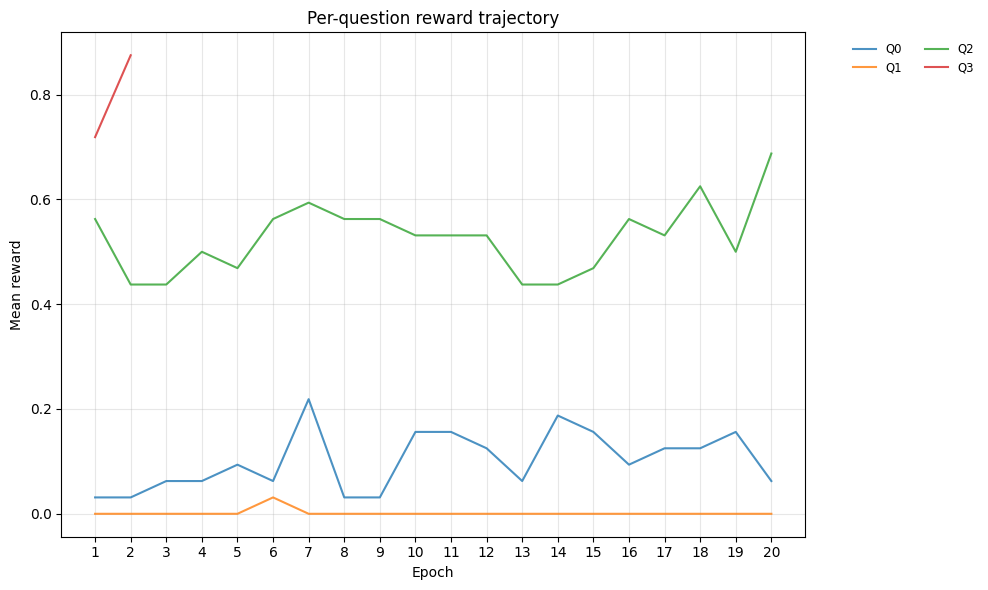

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- reshape rewards ---
# epoch_wide_rewards  -> shape (num_epochs, num_questions)
epoch_wide_rewards = [[item for item in rewards] for rewards in reward_history]
reward_matrix = np.array(epoch_wide_rewards)       # (E, Q)
num_epochs, num_qs = reward_matrix.shape

# --- plot ---
plt.figure(figsize=(10, 6))
x = np.arange(1, num_epochs + 1)

for q in range(num_qs):
    plt.plot(x, reward_matrix[:, q], label=f"Q{q}", alpha=0.8)

plt.title("Per-question reward trajectory")
plt.xlabel("Epoch")
plt.ylabel("Mean reward")
plt.xticks(x)
plt.grid(alpha=0.3)

# put the legend outside so the graph isn’t cluttered
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left",
    ncol=2, fontsize="small", frameon=False
)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np

# -------------------------------------------------
# 1.  Build a (E, Q) array from reward_history
# -------------------------------------------------
reward_matrix = np.asarray([[v for v in row] for row in reward_history],
                           dtype=object)         # keep Nones intact

# -------------------------------------------------
# 2.  Convert to float, using NaN for missing values
# -------------------------------------------------
rm_float = np.full_like(reward_matrix, np.nan, dtype=float)
for i in range(rm_float.shape[0]):
    for j in range(rm_float.shape[1]):
        v = reward_matrix[i, j]
        rm_float[i, j] = np.nan if v is None else float(v)

# -------------------------------------------------
# 3.  Count slopes
# -------------------------------------------------
pos, neg, flat = 0, 0, 0

for q in range(rm_float.shape[1]):
    col = rm_float[:, q]
    idx = np.where(~np.isnan(col))[0]            # finite rows
    if len(idx) < 2:                             # need ≥2 points
        flat += 1
        continue

    first, last = col[idx[0]], col[idx[-1]]
    if last > first:
        pos += 1
    elif last < first:
        neg += 1
    else:
        flat += 1

print(f"Positive-sloping lines: {pos}")
print(f"Negative-sloping lines: {neg}")
print(f"Flat / insufficient data: {flat}")

Positive-sloping lines: 4
Negative-sloping lines: 5
Flat / insufficient data: 31


In [ ]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 3                # demos per query
NUM_SAMPLES = 5             # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder.eval()                                   # no grads!

icl_model = OpenAIICLModel(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
gsm8k_data = load_dataset("gsm8k", "main")["train"].select(range(256))  # slice first 200 examples
gsm8k_to_infer = load_dataset("gsm8k", "main")["train"] \
                     .select(range(20))          # ⬅ change as needed

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

for idx in tqdm(range(len(gsm8k_to_infer)), desc="Baseline eval"):
    item       = gsm8k_to_infer[idx]
    Q_inf, A_gt = item["question"], item["answer"]

    # Build demo pool (everything except current query)
    demos = [(d["question"], d["answer"])
             for j, d in enumerate(gsm8k_data) if j != idx]

    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    print(responses_nested)
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    acc = compute_demo_accuracy(flat_responses, A_gt)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on GSM8K_to_infer: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/20 [00:00<?, ?it/s]

🔍 Top-K Indices: [78, 79, 211]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:   5%|▌         | 1/20 [00:01<00:22,  1.17s/it]

[['48 + (48/2) = 48 + 24 = 72', '48 + (48 / 2) = 48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72'], ['48 + 24 = 72', '72', '48 + 48/2 = 48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '144'], ['48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '48 + 24 = 72', '72', '72']]
0.9333333333333333
🔍 Top-K Indices: [63, 119, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  10%|█         | 2/20 [00:02<00:23,  1.32s/it]

[['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10']]
1.0
🔍 Top-K Indices: [13, 82, 11]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  15%|█▌        | 3/20 [00:03<00:22,  1.30s/it]

[['55', '55', '55', '55', '55'], ['25', '53', '53', '50', '53'], ['55', '70', '55', '55', '55']]
0.9333333333333333
🔍 Top-K Indices: [130, 136, 229]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  20%|██        | 4/20 [00:05<00:19,  1.25s/it]

[['48', '54', '48', '48', '54'], ['60', '60', '60', '60', '60'], ['48', '48', '48', '48', '48']]
0.0
🔍 Top-K Indices: [63, 119, 140]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  25%|██▌       | 5/20 [00:06<00:19,  1.27s/it]

[['312', '312', '312', '312', '312'], ['312', '312', '312', '312', '312'], ['312', '312', '312', '312', '312']]
0.0
🔍 Top-K Indices: [135, 105, 41]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  30%|███       | 6/20 [00:07<00:19,  1.39s/it]

[['130', '110', '110', 'Total yellow flowers = 10  \nPurple flowers = 80% more than yellow = 10 + 0.80 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Total yellow flowers = 10  \nPurple flowers = 80% more than yellow = 10 + 0.80 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35'], ['Yellow: 10\nPurple: 80% more than yellow = 10 * 1.8 = 18\nYellow + purple: 10 + 18 = 28\nGreen: 25% of yellow + purple = 0.25 * 28 = 7\nTotal flowers: 10 + 18 + 7 = 35', 'Yellow = 10  \nPurple = 80% more than yellow = 10 + 0.8 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Yellow: 10  \nPurple: 80% more than yel

Baseline eval:  35%|███▌      | 7/20 [00:09<00:18,  1.39s/it]

[['48', '48', '48', '48', '48'], ['48', '48', '48', '48', '48'], ['48', '48', '48', '48', '48']]
1.0
🔍 Top-K Indices: [91, 18, 17]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  40%|████      | 8/20 [00:10<00:16,  1.38s/it]

[['16', '16', '8', '8', '8'], ['8', '10', '8', '16', '16'], ['8', '16', '16', '16', '16']]
0.5333333333333333
🔍 Top-K Indices: [85, 94, 173]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  45%|████▌     | 9/20 [00:12<00:15,  1.43s/it]

[['41', '41', '41', '61', '61'], ['$41', '$41', '$41', '87', '$41'], ['87', '87', '$41', '$41', '$41']]
0.6666666666666666
🔍 Top-K Indices: [119, 18, 63]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  50%|█████     | 10/20 [00:13<00:13,  1.36s/it]

[['$495', '$405', '$405', '$585', '$405'], ['$270', '90', '$405', '$270', '10*1.5*18=270  \n270*5=1350'], ['$495', '$405', '$495', '$495', '540']]
0.06666666666666667
🔍 Top-K Indices: [223, 42, 142]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  55%|█████▌    | 11/20 [00:15<00:13,  1.45s/it]

[['4', '42', '42', '422', '1'], ['423.5', '422', '423.5', '1', '423'], ['423.5', '423.5', '423.5', '423.5', '423.5']]
0.13333333333333333
🔍 Top-K Indices: [105, 85, 49]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  60%|██████    | 12/20 [00:16<00:11,  1.45s/it]

[['2', '2', '7', "4 lawns x $15 = $60; total money saved = $95 - $15 (change) = $80; money from mowing = $60; remaining money for shoveling = $80 - $60 = $20; shoveling earns $7 each; number of driveways = $20 / $7 ≈ 2.86; since he can't shovel a fraction of a driveway, he must have shoveled 2 driveways.", "4 lawns x $15 = $60  \nTotal money saved before buying shoes = $95 + $15 (change) = $110  \nTotal money from mowing lawns = $60  \nMoney from shoveling driveways = $110 - $60 = $50  \nNumber of driveways shoveled = $50 / $7 ≈ 7.14  \nSince he can't shovel a fraction of a driveway, he shovels 7 driveways"], ['4', '4', '4', '4', '4'], ['3', '5', '4', '4', '10']]
0.2
🔍 Top-K Indices: [5, 211, 82]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  65%|██████▌   | 13/20 [00:18<00:10,  1.46s/it]

[['55', '80', '55', '55', '55'], ['60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (1/2 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85'], ['75', '75', '60 + (1/2 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '75', '75']]
0.4
🔍 Top-K Indices: [241, 48, 117]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  70%|███████   | 14/20 [00:19<00:08,  1.39s/it]

[['$30', '$30', '$40', '$30', '$40'], ['$34', '$10 + $5 + $20 = 35', '$30', '$10 + $5 + $20 = 35', '$40'], ['$20', '$26', '$36', '$34', '$34']]
0.13333333333333333
🔍 Top-K Indices: [2, 3, 130]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  75%|███████▌  | 15/20 [00:20<00:06,  1.35s/it]

[['3', '120 / 8 = 15 (sets of 8 pages)\n15 * 20 = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15 (number of 20-minute segments needed)\n15 * 20 minutes = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15 (number of reading sessions needed)\n15 * 20 = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15  \n15 * 20 = 300 minutes  \n300 / 60 = 5 hours'], ['3', '20/8 = 2.5 minutes per page  \n120 * 2.5 = 300 minutes  \n300 / 60 = 5 hours', '3', '3', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages × 2.5 minutes = 300 minutes  \n300 minutes ÷ 60 = 5 hours'], ['3', '3', '3', '3', '3']]
0.4
🔍 Top-K Indices: [81, 63, 197]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  80%|████████  | 16/20 [00:23<00:07,  1.87s/it]

[['6000', '15000', '15000', '37500', '35000'], ['30000', '$90000', 'Profit per DVD = 2.5 * 6 - 6 = 15 - 6 = 9  \nNumber of DVDs sold in 20 weeks = 500 DVDs/day * 5 days/week * 20 weeks = 500 * 5 * 20 = 50,000  \nTotal profit = 50,000 * 9 = 450,000', '75000', 'Profit per DVD = 6 * 2.5 - 6 = 15 - 6 = 9  \nNumber of DVDs sold in 20 weeks = 500 * 5 * 20 = 50,000  \nTotal profit = 50,000 * 9 = 450,000'], ['$15000', '$132,000', '$22,500', '$15,000', '$7,500']]
0.0
🔍 Top-K Indices: [66, 145, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  85%|████████▌ | 17/20 [00:25<00:05,  1.77s/it]

[['1000', '1000', '$1000', '1000', '$1000'], ['200', "Mike's share = (2/5) * 2500 = 1000  \nMoney left after buying the shirt = 1000 - 200 = 800", "Mike's share = (2 / (2 + 5)) * 2500 = (2 / 7) * 2500 ≈ 714.2857  \nMoney Mike has after buying the shirt = 714.2857 - 200 ≈ 514.2857  \nFinal answer: 514", "Mike's share = (2/5) × 2500 = 1000  \nRemaining after buying the shirt = 1000 - 200 = 800  \nAnswer: 800", "Mike's share is (2/7) of total profit, and Johnson's share is (5/7) of total profit.\n\nJohnson's share = $2500 = (5/7) of total profit  \nTotal profit = $2500 * (7/5) = $2500 * 1.4 = $3500\n\nMike's share = (2/7) of total profit = (2/7) * $3500 = $1000\n\nAfter buying the shirt for $200, Mike has:  \n$1000 - $200 = $800\n\n800"], ['1000', '1000', '714.29', '1000', '1000']]
0.2
🔍 Top-K Indices: [82, 156, 182]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  90%|█████████ | 18/20 [00:27<00:03,  1.81s/it]

[['47', '53', '73', '53', '33'], ['49', '55', '61', '55', '49'], ['53', '49', '26 - 4 = 22 pink hard hats remaining\nJohn takes away 6 pink hard hats and twice as many green hard hats as the pink hard hats he took, so green hard hats taken by John = 2 * 6 = 12\nRemaining pink hard hats = 22 - 6 = 16\nRemaining green hard hats = 15 - 12 = 3\nRemaining yellow hard hats = 24 (none taken)\nTotal remaining hard hats = 16 + 3 + 24 = 43', '26 + 15 + 24 = 65\nCarl takes away 4 pink hard hats: remaining pink = 26 - 4 = 22\nJohn takes away 6 pink hard hats: remaining pink = 22 - 6 = 16\nJohn takes away twice as many green hard hats as pink hard hats he removed: 2 * 6 = 12 green hard hats\nRemaining green hard hats = 15 - 12 = 3\nTotal remaining hard hats = pink + green + yellow = 16 + 3 + 24 = 43', "26 - 4 = 22 (pink hard hats remaining after Carl's removal)  \nJohn takes away 6 pink hard hats, leaving 22 - 6 = 16 pink hard hats in the truck  \nJohn takes away twice as many green hard hats as th

Baseline eval:  95%|█████████▌| 19/20 [00:28<00:01,  1.65s/it]

[['9', '9', '9', '10', '9'], ['9', '9', '9', '9', '9'], ['9', '9', '9', '9', '9']]
0.0
🔍 Top-K Indices: [18, 119, 15]
[INFO] Launching 15 parallel inference tasks...


Baseline eval: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]

[['10', '10', '8', '9', '16'], ['8', '8', '8', '8', '8'], ['16', '16', '16', '16', '20 miles each way, so 40 miles per day for 5 days: 40*5=200 miles  \nWeekend ride: 200 miles  \nTotal miles: 200+200=400 miles  \nTime = Distance / Speed = 400 / 25 = 16 hours']]
0.4

📊  Baseline accuracy on GSM8K_to_infer: 38.333%


In [ ]:
# Save the updated MathBERT model
save_path = "./10k_q4_128_demos_0.1_temp_20_max_steps_on_MATH500_mathbert"  # your save directory
encoder.model.save_pretrained(save_path)
encoder.tokenizer.save_pretrained(save_path)

# LOADING

# from transformers import BertTokenizer, BertModel

# model = BertModel.from_pretrained("./updated_mathbert")
# tokenizer = BertTokenizer.from_pretrained("./updated_mathbert")



('./53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/tokenizer_config.json',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/special_tokens_map.json',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/vocab.txt',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/added_tokens.json')